In [4]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [164]:
import os
from os import listdir
from os.path import isdir, join
from shutil import copyfile

data_path = "/home/vasyaod/work/my-tracks/data"

all_tracks = [f for f in listdir(data_path) if isdir(join(data_path, f))]
#all_tracks = map()

import json

def mF(x):
    with open(data_path + "/" + x + '/trip.json') as f:
      data = json.load(f)
    return (data.get('tags',[]), data_path + "/" + x + '/preview.png', x)

flatten = lambda t: [item for sublist in t for item in sublist]

all_tracks = list(map(mF, all_tracks))
tagged_tracks = list(filter(lambda x : len(x[0]) > 0, all_tracks))
none_tagget_tracks = list(filter(lambda x : len(x[0]) == 0, all_tracks))

tag = "school"

positive_exes = list(filter(lambda x : tag in x[0], tagged_tracks))
negative_exes = list(filter(lambda x : not(tag in x[0]), tagged_tracks))

path = "/home/vasyaod/tmp/2"
if not os.path.exists(path + "/1"):
    os.mkdir(path + "/1")
                      
if not os.path.exists(path + "/0"):
    os.mkdir(path + "/0")

for i in positive_exes:
    copyfile(i[1], f"{path}/1/{i[2]}.png")

for i in negative_exes:
    copyfile(i[1], f"{path}/0/{i[2]}.png")

In [74]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [20]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
classifier_model =        "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])


feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=IMAGE_SHAPE+(3,), trainable=False)



In [127]:
num_classes = 2

#    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
#    model.add(Dense(n_outputs, activation='sigmoid'))
#    model.compile(loss='binary_crossentropy', optimizer='adam')
    
model = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
  feature_extractor_layer,
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_25 (Dense)             (None, 100)               128100    
_________________________________________________________________
dense_26 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 51        
Total params: 2,391,185
Trainable params: 133,201
Non-trainable params: 2,257,984
_________________________________________________________________


In [138]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

batch_size = 32
img_height = 224
img_width = 224

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])

def concat_batches(x, y):
    features1, labels1 = x
    features2, labels2 = y
    return ({feature: tf.concat([features1[feature], features2[feature]], axis=0) for feature in features1.keys()}, tf.concat([labels1, labels2], axis=0))


In [144]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(path),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

#train_ds = concat_batches(augmented_ds, train_ds)

train_ds

Found 106 files belonging to 2 classes.
Using 85 files for training.


<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [115]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(path),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds

Found 106 files belonging to 2 classes.
Using 21 files for validation.


<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [100]:
class_names = np.array(train_ds.class_names)
print(class_names)


['0' '1']


(32, 224, 224, 3)
(32,)


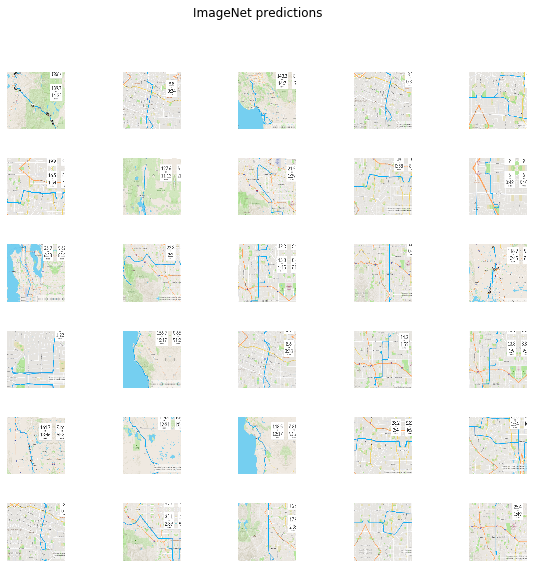

In [132]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
#  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")


In [145]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)


Epoch 1/5
3/3 [==============================] - 3s 877ms/step - loss: 0.0491 - accuracy: 0.9765 - val_loss: 0.2952 - val_accuracy: 0.9048
Epoch 2/5
3/3 [==============================] - 3s 869ms/step - loss: 0.0623 - accuracy: 0.9882 - val_loss: 0.3008 - val_accuracy: 0.9048
Epoch 3/5
3/3 [==============================] - 3s 885ms/step - loss: 0.0579 - accuracy: 0.9882 - val_loss: 0.3102 - val_accuracy: 0.9048
Epoch 4/5
3/3 [==============================] - 3s 875ms/step - loss: 0.0406 - accuracy: 0.9882 - val_loss: 0.3265 - val_accuracy: 0.9048
Epoch 5/5
3/3 [==============================] - 3s 890ms/step - loss: 0.0237 - accuracy: 0.9882 - val_loss: 0.3786 - val_accuracy: 0.9524


In [108]:
history

In [117]:
model.predict(val_ds)

array([[8.9355171e-01],
       [9.0674698e-01],
       [9.2760974e-01],
       [8.4012806e-02],
       [8.3282995e-01],
       [1.0251999e-03],
       [6.1145425e-04],
       [9.2501557e-01],
       [3.9782121e-06],
       [3.5476685e-04],
       [8.4480047e-01],
       [8.8207722e-01],
       [1.4732361e-02],
       [4.5375228e-03],
       [2.6519683e-05],
       [1.9106257e-05],
       [8.9946687e-01],
       [9.4933385e-01],
       [1.0671269e-04],
       [3.2105386e-02],
       [3.2499403e-02]], dtype=float32)

In [161]:
image_size1 = (224, 224)
def prediction(x, caption):
    img = tf.keras.preprocessing.image.load_img(
        x, target_size=image_size1
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = normalization_layer(img_array)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    #print(img_array)
    predictions = model.predict(img_array)
    print(caption, predictions[0][0] > 0.5)
       
    
for i in none_tagget_tracks:
    prediction(i[1], i[2])

20200501 False
20210215 False
20191007 False
20200311 False
20191114 False
20200211 False
20200105 False
20190529 False
20190925 False
20200113 False
20210119 False
20191113 False
20190711 False
20190821 False
20190522 False
20200222 False
20191014 False
20190510 False
20200205 False
20200226 False
20190902 False
20191127 False
20190603 False
20190705 False
20191002 False
20200324 False
20190507 False
20190513 False
20200227 False
20190819 False
20190503 False
20191015 False
20200219 False
20200913 False
20190916 False
20200309 False
20190726 False
20190919 False
20190926 False
20190807 False
20191101 False
20191212 False
20200305 False
20190911 False
20200301 False
20200115 False
20190716 False
20191023 False
20190912 False
20210317 False
20190615 False
20200207 False
20191223 False
20190701 False
20200531 False
20190707 False
20210313 False
20190527 False
20191001 False
20190620 False
20190612 False
20190531 False
20190528 False
20190903 False
20190718 False
20191004 False
20190517 F